Processing: Gandhinagar_SAR_2015.tif


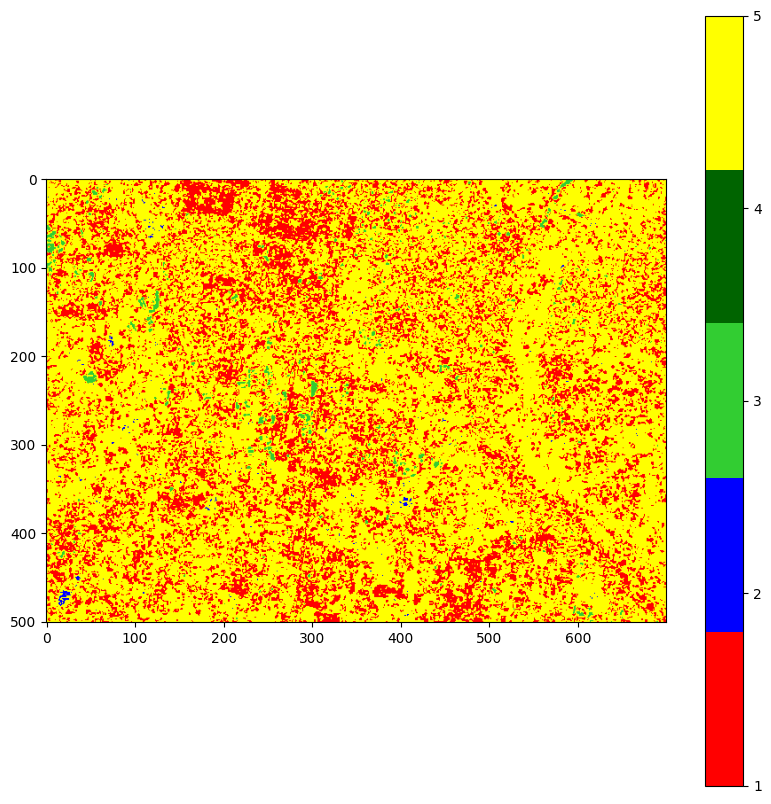

Processing: Gandhinagar_SAR_2016.tif


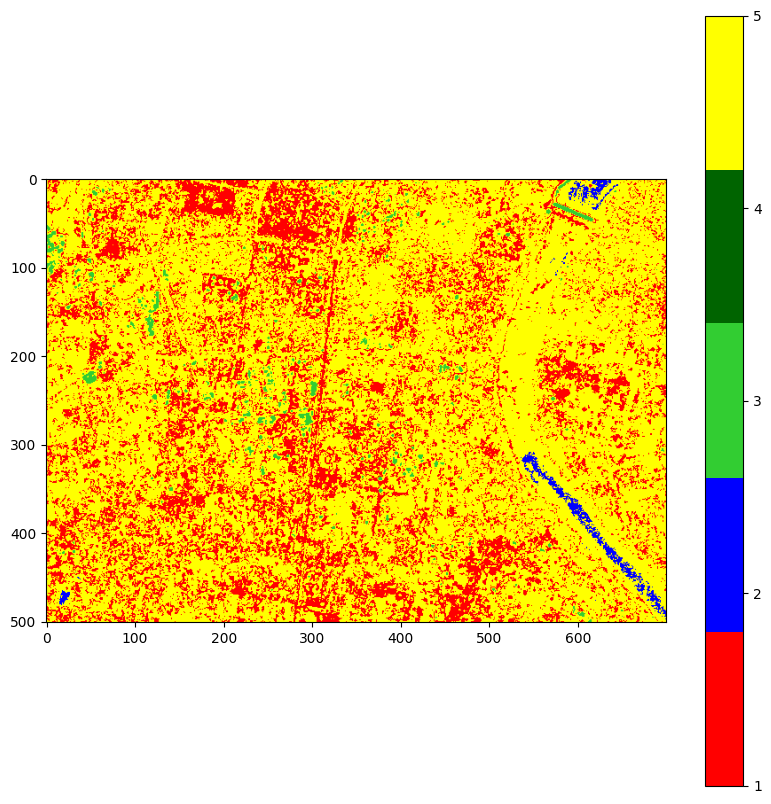

Processing: Gandhinagar_SAR_2017.tif


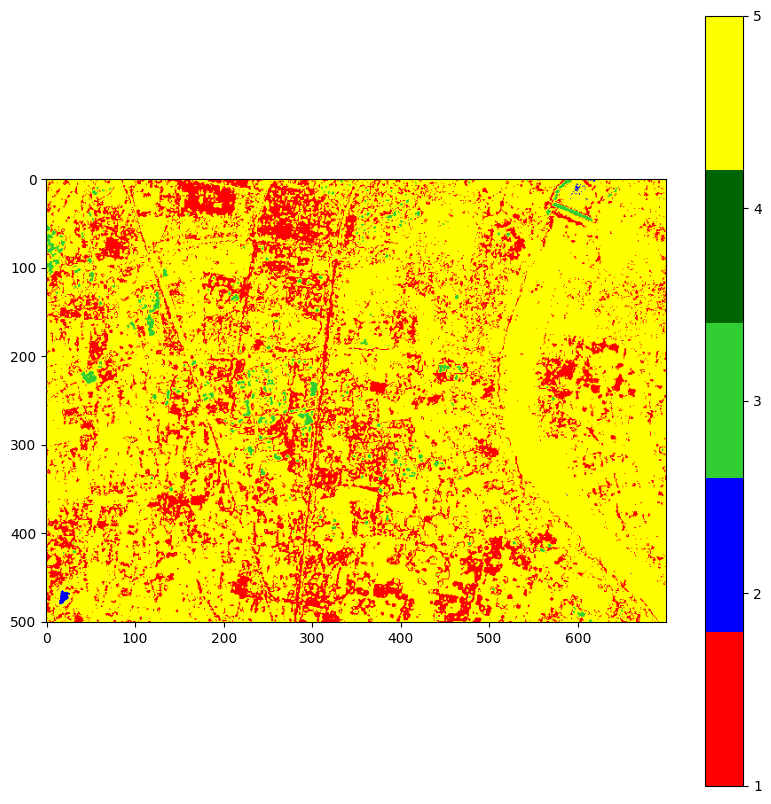

Processing: Gandhinagar_SAR_2018.tif


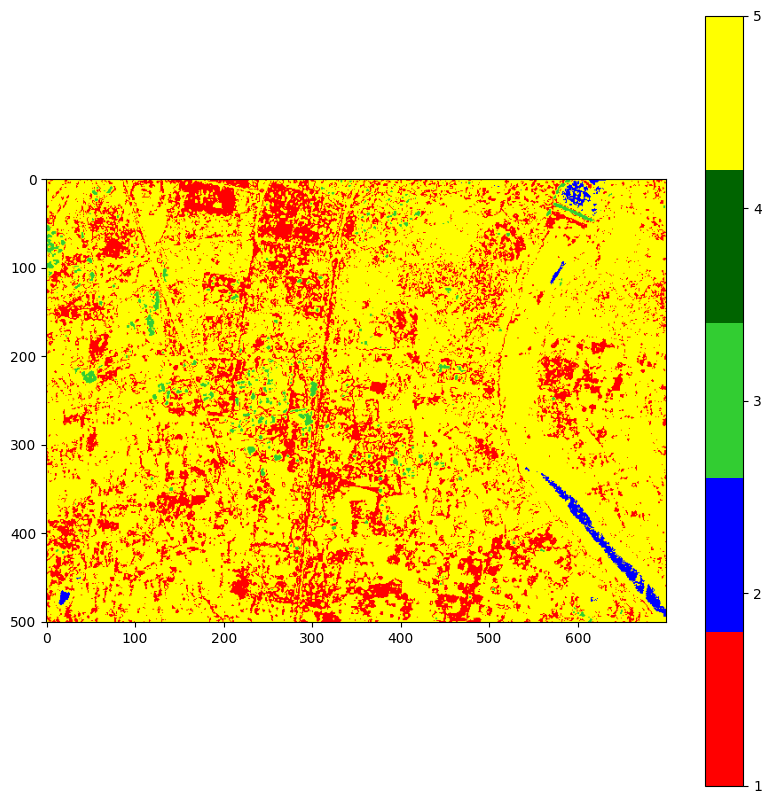

Processing: Gandhinagar_SAR_2019.tif


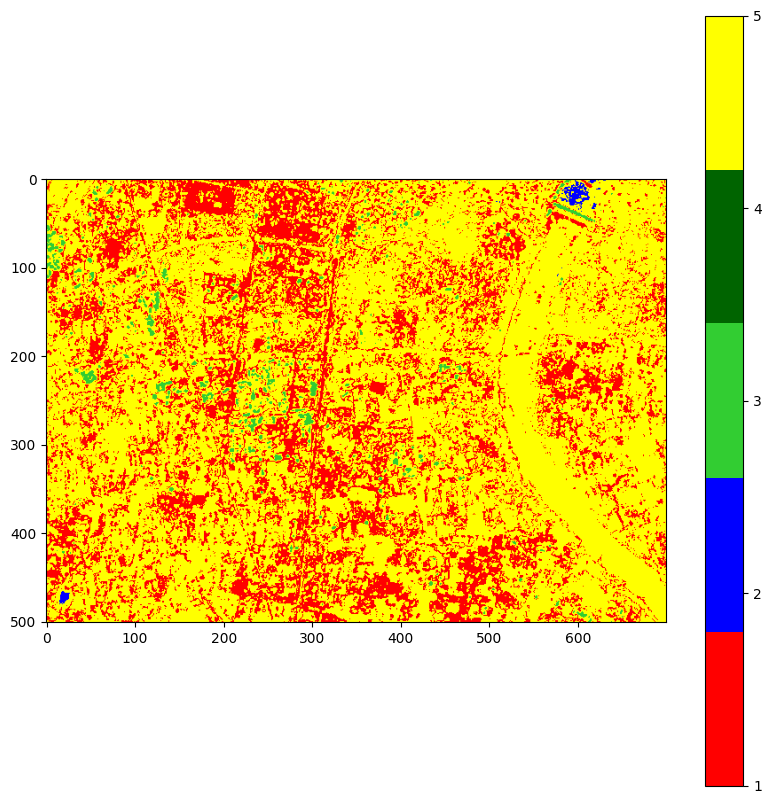

Processing: Gandhinagar_SAR_2020.tif


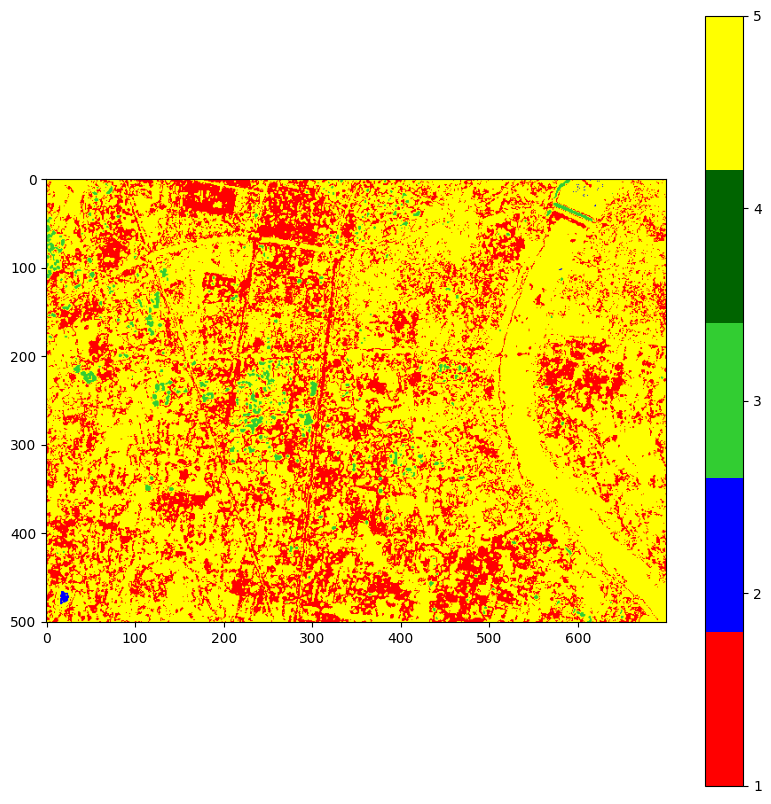

Processing: Gandhinagar_SAR_2021.tif


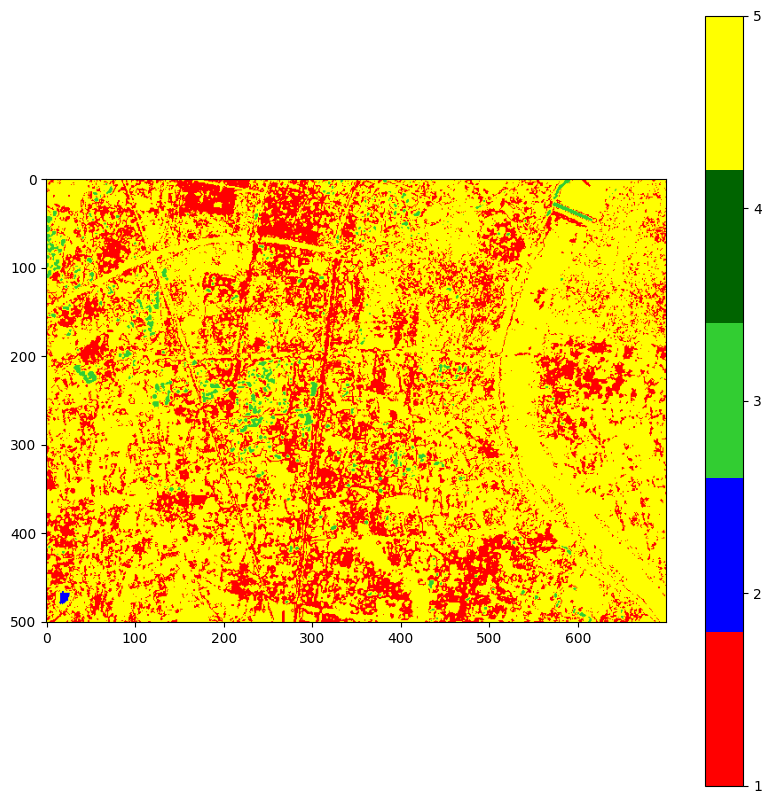

Processing: Gandhinagar_SAR_2022.tif


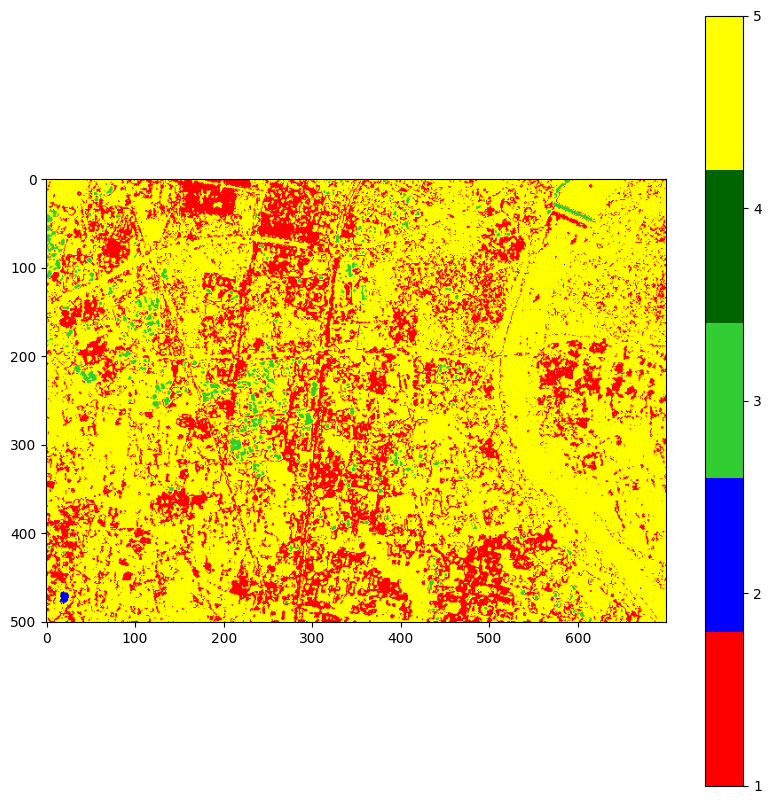

Processing: Gandhinagar_SAR_2023.tif


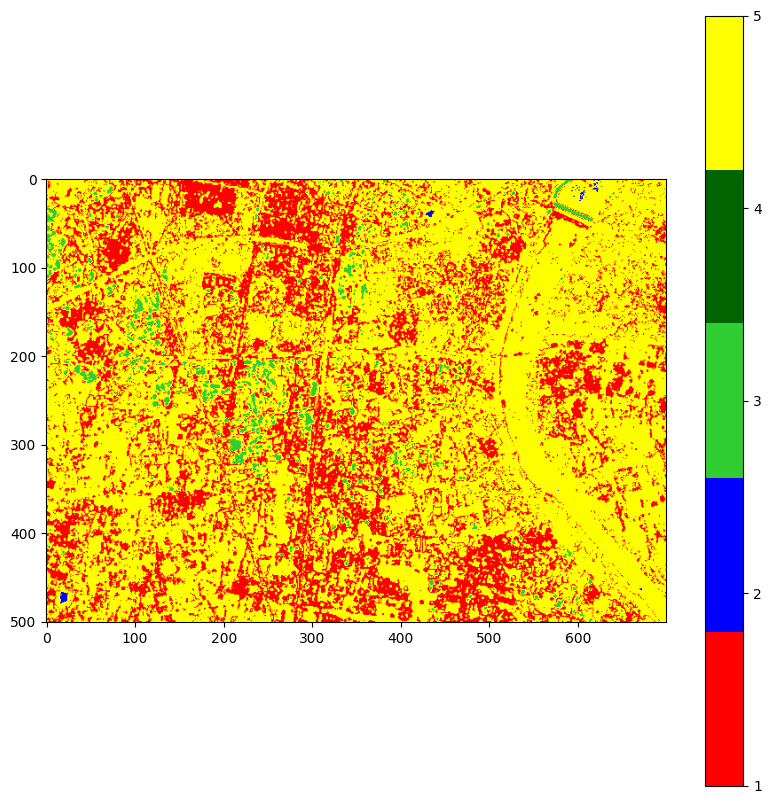

Processing: Gandhinagar_SAR_2024.tif


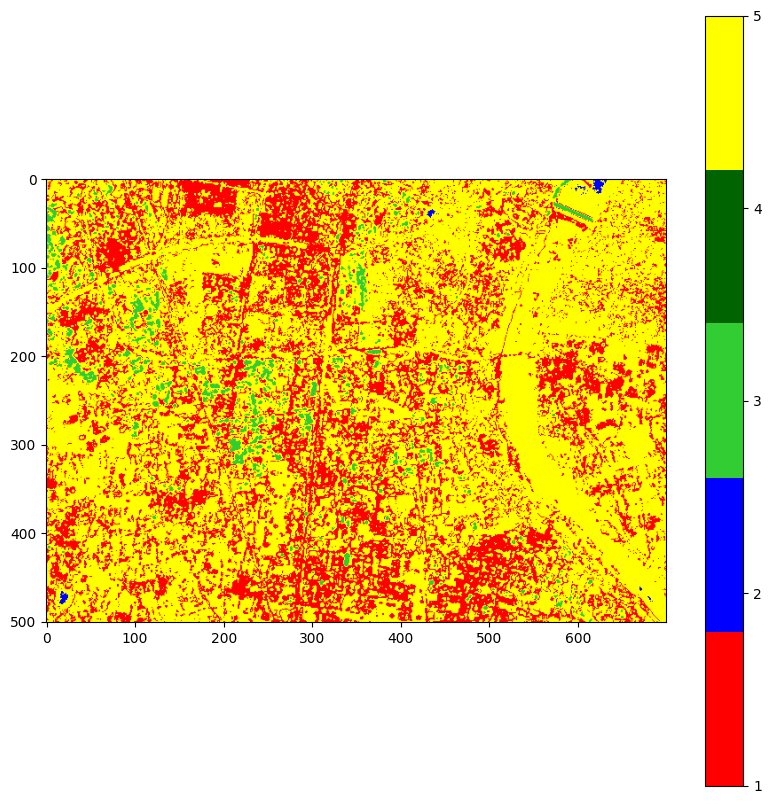

Processing: Gandhinagar_SAR_2025.tif


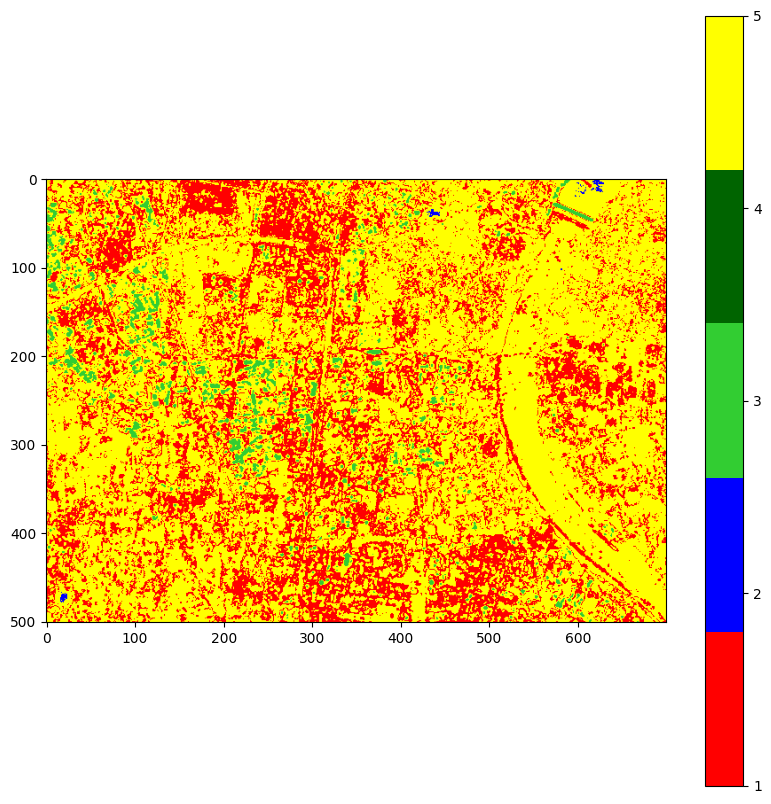

All files processed successfully!


In [11]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os

# Folder containing all your Sentinel-1 TIFFs
input_folder = r"D:\Raagi\Hackathon\Gandhinagar_SAR"
output_folder = r"D:\Raagi\Hackathon\Gandhinagar_SAR\Classified"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# RGB colors for Urban, Water, Vegetation, Forest, Barren
colors_255 = [
    (255, 0, 0),       # Urban
    (0, 0, 255),       # Water
    (50, 205, 50),     # Vegetation
    (0, 100, 0),       # Forest
    (255, 255, 0)      # Barren
]
colors = [(r/255, g/255, b/255) for r, g, b in colors_255]
cmap = ListedColormap(colors)

# Loop through all TIFF files in the folder
for file in os.listdir(input_folder):
    if file.endswith(".tif"):
        tiff_path = os.path.join(input_folder, file)
        print(f"Processing: {file}")
        
        # Read image
        with rasterio.open(tiff_path) as src:
            img = src.read()  # (bands, height, width)
            profile = src.profile

        # Assuming band 1 = VV, band 2 = VH
        vv = img[0]
        vh = img[1]

        # Classification
        classified = np.zeros_like(vv, dtype=np.uint8)
        classified[(vv > -10) & (vh < -15)] = 1  # Urban
        classified[(vv < -20) & (vh < -20)] = 2  # Water
        classified[(vh > -10) & (vv > -15) & (classified == 0)] = 3  # Vegetation
        classified[(vh > -5) & (classified == 0)] = 4  # Forest
        classified[classified == 0] = 5  # Barren

        # Save classified TIFF
        out_profile = profile.copy()
        out_profile.update(dtype=rasterio.uint8, count=1)
        out_tiff = os.path.join(output_folder, f"classified_{file}")
        with rasterio.open(out_tiff, "w", **out_profile) as dst:
            dst.write(classified, 1)

        # Save plot as PNG
        plt.figure(figsize=(10,10))
        im = plt.imshow(classified, cmap=cmap)
        cbar = plt.colorbar(im, ticks=[1,2,3,4,5])
        out_png = os.path.join(output_folder, f"classified_{os.path.splitext(file)[0]}.png")
        plt.savefig(out_png)
        plt.show()
        plt.close()

print("All files processed successfully!")


In [13]:
import cv2
import numpy as np
import os
import pandas as pd

# Folder containing classified PNG images
input_folder = r"D:\Raagi\Hackathon\Output"
# Output CSV file
output_csv = r"D:\Raagi\Hackathon\landcover_percentages.csv"

# RGB color map
rgb_map = {
    "Water": (0, 0, 255),
    "Urban": (255, 0, 0),
    "Vegetation": (50, 205, 50),
    "Forest": (0, 100, 0),
    "Bare Soil": (255, 255, 0)
}

# Prepare list to collect data
data_list = []

# Process all PNG files
for file in os.listdir(input_folder):
    if file.endswith(".png"):
        image_path = os.path.join(input_folder, file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.array(img)
        
        total_pixels = img_array.shape[0] * img_array.shape[1]
        
        features = {}
        for class_name, color in rgb_map.items():
            mask = np.all(img_array == color, axis=-1)
            class_pixels = np.sum(mask)
            features[class_name] = round((class_pixels / total_pixels) * 100, 2)
        
        # Extract year from file name if included, otherwise use file name
        year = ''.join(filter(str.isdigit, file)) or file
        
        row = {"Year": year}
        row.update(features)
        data_list.append(row)

# Convert to DataFrame
df = pd.DataFrame(data_list)
df = df.sort_values("Year")  # optional: sort by year

# Save to CSV
df.to_csv(output_csv, index=False)

print(f"Land cover percentages saved to {output_csv}")


Land cover percentages saved to D:\Raagi\Hackathon\landcover_percentages.csv


In [ ]:
from google.colab import userdata
import json
import google.generativeai as genai

GEMINI_API_KEY = userdata.get('API_Key')

# Initialize Google Gemini AI
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel('gemini-2.5-flash')

def analyze_land_use():
    try:
        document_text = """
        Year   Water   Urban   Vegetation   Forest   Bare Soil
        2015   0.01    2.78    0.05         0        31.71
        2016   0.10    2.72    0.10         0        31.10
        2017   0.01    3.06    0.10         0        46.56
        2018   0.22    3.35    0.10         0        45.03
        2019   0.05    4.44    0.10         0        33.96
        2020   0.01    4.83    0.12         0        32.80
        2021   0.02    5.21    0.12         0        34.77
        2022   0.02    4.73    0.14         0        38.16
        2023   0.01    5.22    0.17         0        33.03
        2024   0.03    5.48    0.25         0        30.30
        2025   0.01    4.79    0.28         0        28.33
        """

        question = """
        Analyze the SAR-derived land use data and provide responses in the following storytelling format:

        For only significant change detected, structure your response as:

        🔹 [Change Type Title]
           Model Prediction:
           Cause:[Primary driver - e.g., Urbanization, Agriculture, Climate Impact]
           Impact:[Consequences - e.g., Loss of bare soil, Vegetation increase, Water stress]
           Storytelling:"[Start with what the data shows in concrete numbers, then explain what this means on the ground. Connect it to real-world activities like construction, farming changes, or environmental shifts. Explain the local implications and what people might be experiencing.explain in brief]"

        Guidelines:
        1. Identify 3-4 most significant changes in the data
        2. For each change, clearly state the cause (what's driving it) and impact (what effects it has)
        3. In storytelling, mention specific years and percentage changes
        4. Connect technical observations to real-world scenarios (e.g., "new housing colonies," "farmers shifting crops," "factory construction")
        5. Keep storytelling natural and relatable - as if explaining to someone familiar with the area
        6. End with an overall summary of land transformation

        Focus on these trends:
        - Urban area changes (from 2.78% to 5.48%)
        - Vegetation changes (from 0.05% to 0.28%)
        - Bare soil changes (from 31.71% to 28.33%)
        - Water fluctuations
        """

        response = model.generate_content(
            f"""
            You are an expert in SAR (Synthetic Aperture Radar) image analysis and land use change detection.

            Based on the following SAR-derived land use classification data, provide a detailed analysis
            in the storytelling format specified below.

            Document content:
            {document_text}

            Question: {question}

            Important: Format your response EXACTLY as shown in the examples, with clear Model Prediction
            sections (Cause and Impact) followed by natural Storytelling sections that connect data to
            real-world observations.
            """
        )

        return json.dumps({
            "success": True,
            "answer": response.text
        }, indent=2)

    except Exception as e:
        print(f"Error answering question: {str(e)}")
        return json.dumps({"success": False, "error": str(e)}), 500

# Call the function to execute the analysis
result = analyze_land_use()
print(result)

# Optional: Parse and display the formatted result
parsed_result = json.loads(result)
if parsed_result["success"]:
    # print("\n" + "="*80)
    # print("LAND USE CHANGE ANALYSIS - STORYTELLING OUTPUT")
    # print("="*80 + "\n")
    print(parsed_result["answer"])